# 1. Preprocessing
The purpose of this notebook is to preprocess CGM data from 95 individual files into one complete file containing: 
- The original 5-minute readings for each individual
- Artificially cut 15-minute data from the 5-minute data
- Interpolated 5-minute data created from interpolating the 15-minute data with various methods

## 1.1. Import packages and upload data

In [1]:
# Import packages and upload dataset
import pandas as pd
import numpy as np
import datetime
import os
from datetime import timedelta as time
from sklearn.gaussian_process import GaussianProcessRegressor
import sklearn.gaussian_process.kernels as k
import warnings
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
mpl.style.use('default')
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# Upload directory for individual data
directory = 'C:\\Users\\cr591\\OneDrive - University of Exeter\\Desktop\\PhD\\Projects\\interpolation-for-hypo-detection\\dexcom-maths-exploration\\data\\raw_data\\data-preprocessed'

## 1.2. Clean and combine CGM files

In [3]:
def round_time(dt=None, roundTo=60):
    """Round a datetime object to any time lapse in seconds
    dt : datetime.datetime object, default now.
    roundTo : Closest number of seconds to round to, default 1 minute.
    Author: Thierry Husson 2012 - Use it as you want but don't blame me.
    """
    dt = dt.to_pydatetime()
    seconds = (dt.replace(tzinfo=None) - dt.min).seconds
    rounding = (seconds+roundTo/2) // roundTo * roundTo
    return dt + datetime.timedelta(0,rounding-seconds,-dt.microsecond)

In [4]:
def combine_frame(filename):
    '''
    Combines data from all participants into 1 file
    '''
    # set filepath for each file in directory
    filepath = directory + '/' + filename
    # Upload cgm dataset for the file
    df = pd.read_csv(filepath)
    df = df[['timestamp', 'sensorglucose']].dropna(how='all')
    df.columns = ['time', 'glc']
    # Set ID from filename
    ID = filename.replace('.csv', '')
    df['ID'] = ID
    df['time'] = pd.to_datetime(df['time'])
    # Round seconds to zero so minute align
    df.time = df.time.apply(lambda x: round_time(x))
    # Replace low and high with values
    df.glc = pd.to_numeric(df.glc.replace({'Low':2.22, 'High':22.22}))\
        .apply(lambda x: 22.22 if x > 22.22 else (2.22 if x < 2.22 else x))
    return df

In [5]:
# Map the function to all files in the directory
results = list(map(combine_frame, os.listdir(directory)))
# Concatenate all files to make one dataframe
df_total = pd.concat(results).reset_index(drop=True)

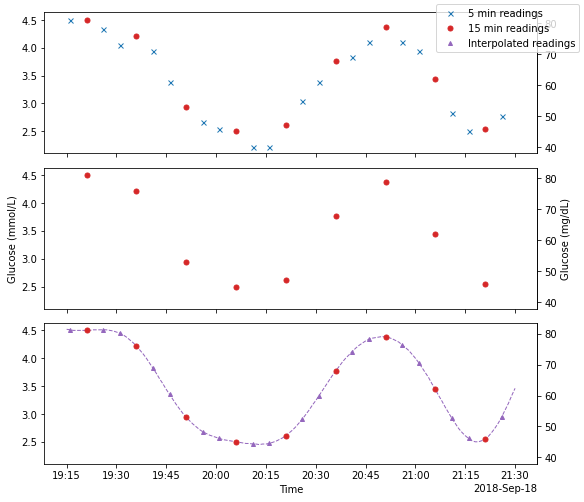

In [6]:
# Functions for determining the British and American glucose axis for the plots
def mmol2mg(x):
    return x / 0.0555
def mg2mmol(x):
    return x * 0.0555
# Load the dataset
df = pd.read_csv('~/OneDrive - University of Exeter/Desktop/PhD/Projects/interpolation-for-hypo-detection/dexcom-maths-exploration/data/tidy_data/interp_dataset.csv')
df['time'] = pd.to_datetime(df['time'])
# Example of hypo from dataset
sub_df = df.loc[(df.ID == '1004_6months') & (df.time >= '18/09/2018 19:15') &
                (df.time <= '18/09/2018 21:30')]
sub_df_5 = sub_df.dropna(subset=['glc'])
# Create matplotlib figure
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(8, 7), sharex=True, 
                                    sharey=True)
# ax1 - 5-minute or glucose readings
#ax1.plot(sub_df_5.time, sub_df_5.glc, 'x', label='5 min readings',
#         markersize=5)
no_15 = sub_df_5[pd.isnull(sub_df_5.cut_glc)]
ax1.plot(no_15.time, no_15.glc, 'x', label='5 min readings', markersize=5)
ax1.plot(sub_df_5.time, sub_df_5.cut_glc, marker='o', color='C3',         
         linestyle='None', label='15 min readings', markersize=5)

# ax2 - 15-minute glucose readings

ax2.plot(sub_df_5.time, sub_df_5.cut_glc, marker='o', color='C3',
         linestyle='None', markersize=5)
# ax3 - interpolated glucose readings
#ax3.plot(no_15.time, no_15.glc, 'x', label='5 min readings', markersize=5)
ax3.plot(sub_df.time, sub_df.polynomial_5, linestyle='--', color='C4', 
         linewidth=1)
ax3.plot(sub_df_5.time, sub_df_5.cut_glc, linestyle='None', marker='o', 
         color='C3', markersize=5)
ax3.plot(no_15.time, no_15.polynomial_5, linestyle='None', marker='^',
         color='C4', label='Interpolated readings', markersize=4)
# Set a joint legend

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

fig.legend(lines, labels)
# Set the axis
for ax in ax1, ax2, ax3:
    secax = ax.secondary_yaxis('right', functions=(mmol2mg, mg2mmol))
    if ax == ax2:
        secax.set_ylabel('Glucose (mg/dL)')
# Set the axis ticker
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(formatter)
# Set the axis labels
ax2.set_ylabel('Glucose (mmol/L)')
ax3.set_xlabel('Time')
fig.tight_layout()
fig.savefig('figure1-bigger.svg')

### 1.2.1 Drop traces with more than 30% missing data

In [7]:
def missing(series):
    notnulls = pd.notnull(series).count()
    perc_complete = notnulls/((7*24*60)/5)*100
    return perc_complete

In [9]:
perc_missing = df_total.groupby('ID').apply(lambda group: missing(group.glc))
ids_to_drop = perc_missing[perc_missing<70].index
df_total = df_total.loc[~df_total['ID'].isin(ids_to_drop)]

In [15]:
# Number of people
len(set(df_total.ID.apply(lambda x: x[:4])))

67

## 1.3. Create 15-minute data

In [24]:
def resample_data(dataframe):
    '''
    Resamples the 5-minute glucose data to 15-minute intervals
    '''
    # List for the indices that will be kept for 15 min dataset
    index_list = []
    # Create column with the difference between each row
    dataframe['diff'] = dataframe.time.diff()
    # Set a counter to zero
    time_counter = time(minutes=0)
    # Loop through all the indices to find ones 15 mins or more apart
    for i, row in dataframe.iterrows():
        # If it's the first row, add the index to the list
        if i == dataframe.index[0]:
            index_list.append(i)
            continue
        # Add the difference between the next row to the time counter
        time_counter += dataframe.loc[i]['diff']
        # When the counter is up to >14 mins, add the index to the list
        if time_counter > time(minutes=14):
            index_list.append(i)
            # Reset the counter 
            time_counter = time(minutes=0)
    # Create a new column with nan values
    dataframe['cut_glc'] = np.nan
    # Set the values in cut_glc with the glc values in the index_list
    dataframe['cut_glc'].loc[index_list] = dataframe['glc'].loc[index_list]
    # Remove the diff column
    dataframe.drop(columns='diff', inplace=True)
    return dataframe

In [25]:
# Apply the function to each ID
df_total = df_total.groupby('ID').apply(resample_data)

In [26]:
df_total.head()

,time,glc,ID,cut_glc
1375,2018-09-21 14:52:00,9.99,1003_6months,9.99
1376,2018-09-21 14:57:00,10.16,1003_6months,NaN
1377,2018-09-21 15:02:00,9.88,1003_6months,NaN
1378,2018-09-21 15:07:00,9.66,1003_6months,9.66
1379,2018-09-21 15:12:00,9.16,1003_6months,NaN


## 1.4. Interpolate 15-minute dataset
Interpolate the 15-minute data using various methods

In [27]:
def resampleDf(df_id):
    '''
    Resample dataset to 1 min intervals
    '''
    # Drop duplicates
    df_id = df_id[~df_id['time'].duplicated(keep='first')]
    # Set time as datetime index
    df_id.set_index('time', inplace=True)
    # Resample to 1 minute intervals 
    df_id = df_id.resample(rule='min', origin='start').asfreq()
    return df_id

In [28]:
# Apply resample functin to each ID
results = df_total.groupby('ID').apply(resampleDf)
# Reset index
results = results.drop('ID', axis=1).reset_index()

In [29]:
results.head(16)

,ID,time,glc,cut_glc
0,1003_6months,2018-09-21 14:52:00,9.99,9.99
1,1003_6months,2018-09-21 14:53:00,NaN,NaN
2,1003_6months,2018-09-21 14:54:00,NaN,NaN
3,1003_6months,2018-09-21 14:55:00,NaN,NaN
4,1003_6months,2018-09-21 14:56:00,NaN,NaN
5,1003_6months,2018-09-21 14:57:00,10.16,NaN
6,1003_6months,2018-09-21 14:58:00,NaN,NaN
7,1003_6months,2018-09-21 14:59:00,NaN,NaN
8,1003_6months,2018-09-21 15:00:00,NaN,NaN
9,1003_6months,2018-09-21 15:01:00,NaN,NaN


### 1.4.1. Interpolate using Pandas SciPy wrappers

In [30]:
def interpolate(resampled_dataframe, method, limit, order=5):
    '''
    Interpolate a resampled series with a method of choice from the Pandas
    interpolation wrapper
    '''
    # If the method is polynomial or spline, an order needs to be given
    if (method == 'polynomial') | (method == 'spline'):
        interp_series = resampled_dataframe.interpolate(method=method, 
                                                     limit_area='inside',
                                                     limit_direction='forward',
                                                     limit=limit, order=order)
    # Else no order is needed
    else:
        interp_series = resampled_dataframe.interpolate(method=method,
                                                     limit_area='inside',
                                                     limit_direction='forward',
                                                     limit=limit)
    return interp_series

### 1.4.2. Interpolation with Gaussian process regression

In [31]:
def gp_interp(resampled_dataframe):
    '''
    Interpolate using SciKit Learn's implementation of Gaussian Process (GP) 
    using RBF, rational quadratic and Matern kernels
    '''
    # Create a timestamp for the GP
    resampled_dataframe['timestamp'] = resampled_dataframe.time.apply(lambda x: x.timestamp())
    # Y_train is the 15-minute glucose data
    Y_train = resampled_dataframe.dropna().cut_glc
    # X_train is the timestamp in 2d form for the 15-min data
    X_train = np.atleast_2d(resampled_dataframe.dropna(subset=['cut_glc']).timestamp).T
    # X_test is the 1-min data we are predicting
    X_test = resampled_dataframe.timestamp
    # Y_test is the 1-min glucose data
    Y_test = resampled_dataframe.glc
    # Declare the kernels and set the length scale bounds
    rbf = k.RBF(length_scale=1, length_scale_bounds= (400, 900))
    rq = k.RationalQuadratic(length_scale=1, length_scale_bounds= (400, 900),
                                alpha=0)
    matern = k.Matern(length_scale=1, length_scale_bounds= (400, 900), nu=3.5)
    kernels = {'matern': matern, 'rq': rq, 'rbf': rbf}
    # For each of the kernels, fit a GP to predict the missing values
    for kernel in kernels:
        # Declare GP
        gp = GaussianProcessRegressor(kernel=kernels[kernel], alpha=0,
                                      n_restarts_optimizer=4)
        # Fit to 15-min data
        gp.fit(X_train, Y_train)
        # Predict 1-min data
        y_mean= gp.predict(X_test[:, None]) #, return_std=True)
        # Create new column in the dataframe to fit predicted values
        resampled_dataframe[kernel] = y_mean
    return resampled_dataframe

### 1.4.3. Combine all methods to create interpolated dataset

In [32]:
def combine_interpolation_frames(dataframe):
    '''
    Combine all interpolation methods into one dataframe
    '''
    # All the interpolation methods to be used
    interp_methods = ['pchip', 'linear', 'cubicspline', 'akima', 'polynomial']
    # 15-minute data will be used for interpolation
    col = dataframe.cut_glc
    # Limit is 15 minutes for interpolation
    limit = 15
    # Run each method through the interpolate function 
    for method in interp_methods:
        if method != 'polynomial':
            name = method
            dataframe[name] = interpolate(col, method, limit)
        else:
            # Use 3 different orders for the polynomial interpolation
            for i in [3, 5, 7]:
                name = method + '_' + str(i)
                dataframe[name] = interpolate(col, method, limit, order=i)
    # Interpolate using gaussian process interpolation
    dataframe = gp_interp(dataframe)
    return dataframe

In [34]:
total_results = results.groupby('ID').apply(combine_interpolation_frames)
total_results.head()

,ID,time,glc,cut_glc,pchip,linear,cubicspline,akima,polynomial_3,polynomial_5,polynomial_7,timestamp,matern,rq,rbf
0,1003_6months,2018-09-21 14:52:00,9.99,9.99,9.990000,9.990,9.990000,9.990000,9.990000,9.990000,9.990000,1.537542e+09,9.990000,9.990000,9.990000
1,1003_6months,2018-09-21 14:53:00,NaN,NaN,9.988163,9.968,10.099140,10.024608,10.099140,10.220586,10.297023,1.537542e+09,10.164117,10.021832,10.143945
2,1003_6months,2018-09-21 14:54:00,NaN,NaN,9.982758,9.946,10.184694,10.053415,10.184694,10.393976,10.522341,1.537542e+09,10.300080,10.038180,10.268619
3,1003_6months,2018-09-21 14:55:00,NaN,NaN,9.973944,9.924,10.247782,10.075893,10.247782,10.516043,10.676356,1.537542e+09,10.398999,10.041363,10.364017
4,1003_6months,2018-09-21 14:56:00,NaN,NaN,9.961878,9.902,10.289522,10.091515,10.289522,10.592307,10.768559,1.537542e+09,10.462900,10.034518,10.430511


In [35]:
# Make sure there's no nan values in the interpolation
total_results.dropna(subset=['pchip'], inplace=True)
# Reset the index and round to 2 decimal places to match the CGM readings
total_results.reset_index(drop=True, inplace=True)
total_results = total_results.round(2)

In [36]:
# Drop nan values in the 5-min data to get 5 min rather than 1 min data
total_results.dropna(subset=['glc']).head()

,ID,time,glc,cut_glc,pchip,linear,cubicspline,akima,polynomial_3,polynomial_5,polynomial_7,timestamp,matern,rq,rbf
0,1003_6months,2018-09-21 14:52:00,9.99,9.99,9.99,9.99,9.99,9.99,9.99,9.99,9.99,1.537542e+09,9.99,9.99,9.99
5,1003_6months,2018-09-21 14:57:00,10.16,NaN,9.95,9.88,10.31,10.10,10.31,10.63,10.81,1.537542e+09,10.49,10.02,10.47
10,1003_6months,2018-09-21 15:02:00,9.88,NaN,9.83,9.77,10.15,10.01,10.15,10.35,10.45,1.537542e+09,10.27,9.92,10.29
15,1003_6months,2018-09-21 15:07:00,9.66,9.66,9.66,9.66,9.66,9.66,9.66,9.66,9.66,1.537542e+09,9.66,9.66,9.66
20,1003_6months,2018-09-21 15:12:00,9.16,NaN,9.14,8.96,8.97,8.99,8.97,8.86,8.82,1.537543e+09,8.88,9.01,8.87


In [63]:
total_results.to_csv('interp_dataset.csv', index=False)

In [60]:
total_results = total_results.loc[~total_results['ID'].isin(ids_to_drop)]